In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Step-1: Data gathering

In [ ]:
data=pd.read_csv('Data/train.csv',index_col='PassengerId')
data

In [ ]:
df=data.copy()
df

# Step-2: data preprocessing

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df.drop_duplicates(inplace=True)

    |  Droped unnecessary columns

In [ ]:
df.drop(columns=['Name','Cabin'],inplace=True)

In [ ]:
df.info()

In [ ]:
data.info()

    | Changing Data type

In [ ]:
df.select_dtypes('object') # Select only those columns which data type is object 

In [ ]:
data.select_dtypes('object')[['Sex']].value_counts()

In [ ]:
df.select_dtypes('object')['Ticket'].value_counts() # there is too many category

In [ ]:
df.info()

In [ ]:
df.drop(columns=['Ticket'],inplace=True)

In [ ]:
df.select_dtypes('object')['Embarked'].value_counts() 

In [ ]:
df.Sex.astype('category').cat.codes # it covert one datatype to another datatype

In [ ]:
df.select_dtypes('object').columns

In [ ]:
for obj_col in df.select_dtypes('object').columns:
    df[obj_col]=df[obj_col].astype('category').cat.codes


In [ ]:
df.info()

In [ ]:
df.Embarked.value_counts()

In [ ]:
df.describe().T

In [ ]:
plt.figure(figsize=(7,4))
sns.set(style='white')
sns.boxplot(df.Age)
plt.grid()
plt.show()

    | Imputing missing values
#(class) KNNImputer: 

KNNImputer() uses nearest neighbors(data) to fill the missing values and returns all data into numpy array

Imputation for completing missing values using k-Nearest Neighbors.

Each sample's missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

#Parameters

missing_values : int, float, str, np.nan or None, default=np.nan

n_neighbors : int, default=5
    Number of neighboring samples to use for imputation.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
# Demo
X = [[1, np.nan,4], [3, 4, 3], [np.nan, 4,5], [8, np.nan, 7]]
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X)

In [ ]:
imputer = KNNImputer()
imputer.fit(X=df) # fit() understands and adapts the given data |fit specifies a training process 

In [ ]:
imputed_np = imputer.transform(df) # after fitting/calculating transform data one type to another | here after fitting transform() fills the missing values and return all data as numpy array

In [ ]:
imputed_np.shape

In [ ]:
type(imputed_np)

In [ ]:
imputed_df = pd.DataFrame(imputed_np, columns=df.columns, dtype=np.float16) # numpy.ndarray transfer into dataFrame again
imputed_df.head(2)

In [ ]:
imputed_df.info()


    | Note:

dtype=np.float16 resizes/chages the data type that might be int32, float64, str0, object0 (object means string data type)

In [ ]:
imputed_df

In [ ]:
imputed_df.isnull().sum()

In [ ]:
imputed_df.info()

In [ ]:
sns.pairplot(imputed_df, hue='Survived') 

Here All datas is in categorical format. Hence, Relationships are very difficult to pinpoint

    | Handling imbalance dataset

In [ ]:
imputed_df.Survived.value_counts() # When checking the balance, we use the targate cloumn

| Here we have little imbalance

In [ ]:
sns.barplot(x=['Not Survived','Survived'], y=imputed_df.Survived.value_counts())

| imblearn is a library which deal with imbalanced dataset

In [ ]:
from imblearn.under_sampling import NearMiss # under sampling module
from imblearn.over_sampling import RandomOverSampler # over sampling module

    | Over_sampling

In [ ]:
over_sampler = RandomOverSampler(random_state=42)

In [ ]:
X_features=imputed_df.drop(columns=['Survived'])
X_features

In [ ]:
Y_target=imputed_df[['Survived']]
Y_target

In [ ]:
features,target=over_sampler.fit_resample(X_features,Y_target) # training the dataset

In [ ]:
features.shape, target.shape

In [ ]:
#features['Survived'] = target

# Step-3: Exploratory Data Analysis (EDA)

In [ ]:
features.describe().T

In [ ]:
df.groupby(by='Survived').mean()

In [ ]:
features.Survived.value_counts()

    | Data Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(features,target, random_state=42, test_size=0.25)

In [ ]:
xtrain.shape, xtest.shape

# Step-4: Feature engineering/selection

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
scores = mutual_info_classif(xtrain, ytrain, n_neighbors=5, random_state=42)
scores


In [ ]:
scores = pd.DataFrame(scores, index=features.columns, columns=['Scores',])
scores 

In [ ]:
scores = scores.sort_values(by='Scores', ascending=False)
scores

In [ ]:
sns.barplot(data=scores, x=scores.index, y='Scores')

In [ ]:
features.head(2)

# Step-5: Training model

    | Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=8, max_leaf_nodes=35, n_estimators=100)

In [ ]:
clf.fit(xtrain[['Fare','Sex']], ytrain)

# Step-6: Test model/Model evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
ypred = clf.predict(xtest[['Fare', 'Sex']])
ypred

In [ ]:
cm = confusion_matrix(ytest, ypred)
cm

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Not Survived'])
cmd.plot()

In [ ]:
accuracy_score(ytest, ypred) # Accuracy test

# Step-7: Hyper Parameter tuning

In [ ]:
RandomForestClassifier().get_params()

In [ ]:
params = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 9, 1),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': np.arange(25, 50, 5),
    'min_samples_split':np.arange(2, 20, 3),
    'n_estimators': [50, 100, 200],
    'warm_start': [False, True]
    }

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
grid = RandomizedSearchCV(clf, param_distributions=params, cv=5, scoring='accuracy')
grid.fit(features[['Fare', 'Sex']], target)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_score_

    | ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
ypred_prob = clf.predict_proba(xtest[['Fare', 'Sex']])
ypred_prob # return accuracy values of all possible outcome

In [134]:
fpr, tpr, thresh = roc_curve(ytest, ypred_prob[:,1])

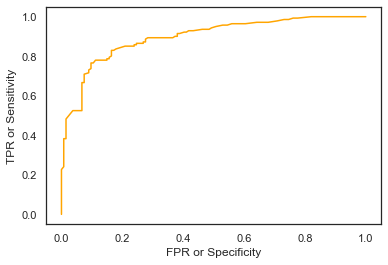

In [135]:
plt.plot(fpr, tpr, color='orange')
plt.ylabel("TPR or Sensitivity")
plt.xlabel("FPR or Specificity")
plt.show()